# Expert-Specific Memory and Guardrails


**Goal**: Upgrade the chatbot (Lean & Supply Chain experts) with two key features:

1. **Isolated Memory:** Use thread_id to ensure each expert remembers its own separate conversation history.

2. **LLM Guardrails:** Implement a specific node before the answer generation to check relevance.

* If relevant: The bot answers.
* If off-topic: The bot blocks the question and returns a warning.

In [91]:
#!pip install langgraph langchain[openai]

In [92]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)

api_key_file = '/content/drive/MyDrive/api_key.txt'
with open(api_key_file, 'r', encoding = 'utf-8-sig') as file:
    api_key = file.read().strip()

print(api_key is not None)
os.environ['OPENAI_API_KEY'] = api_key
print("OpenAI API key loaded:", os.environ.get('OPENAI_API_KEY') is not None)

Mounted at /content/drive
True
OpenAI API key loaded: True


In [93]:
from typing_extensions import TypedDict, List, Annotated

from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages

from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI

from uuid import uuid4


llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0)

class ChatState(TypedDict, total = False):
    messages: Annotated[List[BaseMessage], add_messages]            # Reducer
    guardrials:bool | str
    expertise: str

In [94]:
SYSTEM_PROMPTS:dict = {'Lean Expert': "You are a Lean Manufacturing Consultant - Expert in waste reduction, continuous improvement, Kaizen, 5S, value stream mapping. ",
					   'SCO Expert': "You are a Supply Chain Optimization Expert - Expert in inventory management, logistics, demand forecasting, supplier relationships."}


def guardrails_node(state:ChatState)->dict:
    '''
    Enter the user message to an LLM that return True if is about expertise topic & False if isn't.
    '''
    user_prompt: HumanMessage = state['messages'][-1]      # Human Message
    user_expertise_choice:str = state['expertise']         # Human choice expertise
    if user_expertise_choice is not None:
      system_msg_content = (
                  f"You are a filter for a specialized assistant in: {user_expertise_choice}.\n"
                  "Analyze the user's message.\n"
                  "Return 'True' if the message is:\n"
                  "1. Related to the topic (technical questions).\n"
                  "2. A greeting or self-introduction (e.g., 'Hello', 'I am Nathan').\n"
                  "3. A question about the conversation history or user identity (e.g., 'What is my name?', 'What did we just talk about?').\n\n"
                  "Return 'False' ONLY if the message is clearly completely off-topic (e.g., asking for a cooking recipe, sports results, or general knowledge unrelated to the user or topic).\n"
                  "The response must be strictly 'True' or 'False'."
              )
      system_prompt = SystemMessage(content = system_msg_content)
      response_system: AIMessage = llm.invoke(input = [system_prompt, user_prompt])
      response_bool:bool = eval(response_system.content)
      return {'guardrials': response_bool}


def route(state:ChatState):
    '''
    Define the route for the `conditional_edges`.
    '''
    return 'topic' if state['guardrials'] else 'not topic'


def warning_node(state:ChatState):
    '''
    Message to return id it's not about the expertise topic.
    '''
    warning_msg = AIMessage(content = "Your question is not related to the expert topic.")
    return {"messages": [warning_msg]}


def answer_node(state:ChatState)->dict:
    '''
    If it's about the topic, no change & using regular LLM.
    '''
    prompt_user:HumanMessage = state['messages']
    user_expertise:str = state['expertise']                   # Value of the key: 'expertise'

    prompt_expert:str = SYSTEM_PROMPTS[user_expertise] if user_expertise in SYSTEM_PROMPTS.keys() else "You are a helpful assistant."

    expert = SystemMessage(content = prompt_expert)
    llm_response:AIMessage = llm.invoke(input = [expert] + prompt_user)
    return {'messages': [llm_response]}


In [95]:
checkpointer = MemorySaver()

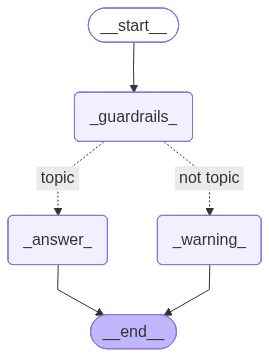

In [96]:
builder = StateGraph(ChatState)

# NODES
builder.add_node('_guardrails_', guardrails_node)
builder.add_node('_answer_', answer_node)
builder.add_node('_warning_', warning_node)

# EDGES
builder.add_edge(START, '_guardrails_')
builder.add_conditional_edges('_guardrails_', route, {'topic': '_answer_', 'not topic': '_warning_'})
builder.add_edge('_warning_', END)
builder.add_edge('_answer_', END)

graph = builder.compile(checkpointer = checkpointer)
graph

In [97]:
from pprint import pprint

config:dict = {'Lean Expert': {'configurable': {'thread_id': str(uuid4())}},
               'SCO Expert': {'configurable': {'thread_id': str(uuid4())}}}

def invoke(user_message:str, expertise:str, config = config):

   thread_id = config[expertise]['configurable']['thread_id']
   print(f'Thread ID: {thread_id}')
   msg = graph.invoke({'messages': [HumanMessage(content = user_message)], 'expertise': expertise}, config = config[expertise])
   return msg


def printing_response(message_user):
  for i in range(len(message_user['messages'])):
      print(i, message_user['messages'][i].content)

In [98]:
msg_user = invoke(user_message = 'Hello, my name is Nathan Douieb and I run a shoe factory.?', expertise = 'Lean Expert')

Thread ID: f9eac42e-8ea1-4d77-af06-cb89a22fa2d8


In [102]:
msg_user = invoke(user_message = 'Just one thing, what is my name ?', expertise = 'Lean Expert')

Thread ID: f9eac42e-8ea1-4d77-af06-cb89a22fa2d8


In [103]:
printing_response(message_user = msg_user)

0 Hello, my name is Nathan Douieb and I run a shoe factory.?
1 Hello Nathan! It's great to meet you. Running a shoe factory presents unique challenges and opportunities for improvement. How can I assist you today? Are you looking to reduce waste, improve efficiency, or implement specific Lean practices like 5S or Kaizen?
2 Just one thing, what is my name ?
3 Your name is Nathan Douieb. How can I assist you further today?


In [104]:
# Testing with SCO expert - testing memory too
msg_user = invoke(user_message = 'What is my name again?', expertise = 'SCO Expert')
printing_response(message_user = msg_user)

Thread ID: d8c5276c-d478-4cd8-8e55-8c7a499a5d24
0 What is my name again?
1 I'm sorry, but I don't have access to personal information about you, including your name. How can I assist you today?


Thread ID changed ! Amazing !